In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# import SummaryWriter
from torch.utils.tensorboard import SummaryWriter

# import the MNIST dataset
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms

import torchsummary

from sklearn.model_selection import train_test_split

# from torchdiffeq import odeint, odeint_adjoint

import cv2
import numpy as np

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

from tqdm.notebook import trange

from src.utils import create_gaussian_dataset, add_spatial_encoding, stack_dataset
from src.models import ConvAE, ConvAEwithResNet

In [57]:
# use the ball dataset

dataset = create_gaussian_dataset(r_min=3.0, r_max=3.0, n_samples=30000, size=28, margin=0, n_balls=1)
dataset = add_spatial_encoding(dataset)
# dataset = stack_dataset(dataset)

train_dataset, test_dataset = train_test_split(dataset, test_size=0.3)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [3]:
# # load the moving MNIST resized dataset 
# data = np.load('data/MOVING_MNIST/mnist_test_seq_resized.npy')
# data = data.reshape(-1, 1, 28, 28)
# data = data.astype(np.float32)
# data = (data - data.min()) / (data.max() - data.min())
# data = [(image, 0) for image in data]
# data = add_spatial_encoding(data)


# train_dataset, test_dataset = train_test_split(data, test_size=0.3)

# # train_data = [(x,0) for x in train_data]
# # test_data = [(x,0) for x in test_data]

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [91]:
# SiLU, ELU, GELU
ae = ConvAE(height=28, width=28, latent_dim=25, in_channels=3, relu=False, activation=nn.ReLU())

Number of parameters in the model: 276028


In [94]:
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
# optimizer = torch.optim.RMSprop(vae.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9999)

In [ ]:
ae.fit(train_loader, test_loader, optimizer, scheduler, loss_fn, epochs=100, display_step=1, n_plot=3)

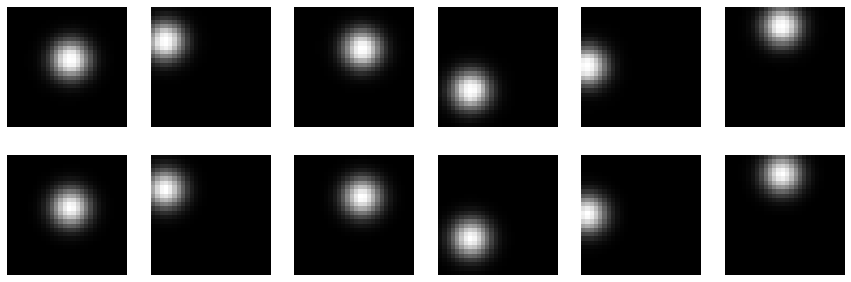

In [96]:
# use the VAE to reconstruct images and there initial images
N_samples_recon = 6
plot_loader = DataLoader(test_dataset, batch_size=N_samples_recon)
ae.eval()
with torch.no_grad():
    limit = np.random.randint(0, int(len(test_dataset)/N_samples_recon))
    for i, data in enumerate(plot_loader):
        if i <= limit:
            continue
        input_image, _ = data
        input_image = input_image.float()
        img = ae(input_image)
        img = img[:,0].cpu().detach().numpy()
        img = np.reshape(img, (N_samples_recon, 28, 28))
        input_image = input_image[:,0].cpu().detach().numpy()
        input_image = np.reshape(input_image, (N_samples_recon, 28, 28))
        height_plot = 5 
        width_plot = height_plot * int(np.ceil(N_samples_recon/2))
        fig, ax = plt.subplots(figsize=(width_plot,height_plot))
        for i in range(N_samples_recon):
            plt.subplot(2, N_samples_recon, i+1)
            plt.imshow(img[i], cmap='gray')
            plt.axis('off')
            
        for i in range(N_samples_recon):
            plt.subplot(2, N_samples_recon, i+1+N_samples_recon)
            plt.imshow(input_image[i], cmap='gray')
            plt.axis('off')
        plt.show()
        break



In [97]:
torch.save(ae.state_dict(), 'models/AE/AE_with_smooth_activation/ae_1_Ball_with_sp_latent_25_no_relu_activation_ReLU_no_margin.pth')